In [1]:
import numpy as np
import pandas as pd
from yahooquery import Ticker

In [2]:
%matplotlib inline

In [3]:
class BayesTable:
    def __init__(self, lambdas, prior, num_evidences):
        self.df = self._make_df(lambdas, prior, num_evidences)
    
    def _column_names(self, num_evidences, row_len):
        cols = []
        max_val = row_len / num_evidences
        cur_evidence = 0
        sub = 0
        for i in range(row_len):
            cols.append(f'e{cur_evidence + 1}{sub + 1}')
            sub += 1
            if sub == max_val:
                cur_evidence += 1
                sub = 0

        return cols
    
    def _make_df(self, lambdas, prior, num_evidences):
        df = pd.DataFrame(lambdas, index=[f'H{i+1}' for i in range(len(prior))])
        df.columns = self._column_names(num_evidences, len(df.columns))
        df['prior'] = prior
        return df

    def __repr__(self):
        return repr(self.df)
    
    def __call__(self):
        return self.df
    
    def evidence(self, e):
        df = self.df.copy()
        unnorm = df[e] * df['prior']
        df['updated'] = unnorm / unnorm.sum()
        return df
    
    def evidences(self, e_list):
        original_df = self.df.copy()
        for e in e_list:
            df = self.evidence(e)
            df = df.drop(['prior'], axis=1).rename({'updated': 'prior'}, axis=1)
            self.df = df
        
        r = self.df.rename({'prior': 'final'}, axis=1)
        self.df = original_df
        return r

In [4]:
table = BayesTable([
    [0.50, 0.40, 0.10, 0.50, 0.40, 0.10],
    [0.06, 0.50, 0.44, 0.06, 0.50, 0.44],
    [0.50, 0.10, 0.40, 0.50, 0.10, 0.40],
    [1.00, 0.00, 0.00, 1.00, 0.00, 0.00]
], [0.099, 0.0099, 0.0001, 0.891], 2)

In [5]:
table()

,e11,e12,e13,e21,e22,e23,prior
H1,0.50,0.4,0.10,0.50,0.4,0.10,0.0990
H2,0.06,0.5,0.44,0.06,0.5,0.44,0.0099
H3,0.50,0.1,0.40,0.50,0.1,0.40,0.0001
H4,1.00,0.0,0.00,1.00,0.0,0.00,0.8910


In [6]:
table.evidence('e13')

,e11,e12,e13,e21,e22,e23,prior,updated
H1,0.50,0.4,0.10,0.50,0.4,0.10,0.0990,0.692501
H2,0.06,0.5,0.44,0.06,0.5,0.44,0.0099,0.304701
H3,0.50,0.1,0.40,0.50,0.1,0.40,0.0001,0.002798
H4,1.00,0.0,0.00,1.00,0.0,0.00,0.8910,0.000000


In [7]:
table.evidences(['e13', 'e21'])

,e11,e12,e13,e21,e22,e23,final
H1,0.50,0.4,0.10,0.50,0.4,0.10,0.946217
H2,0.06,0.5,0.44,0.06,0.5,0.44,0.049960
H3,0.50,0.1,0.40,0.50,0.1,0.40,0.003823
H4,1.00,0.0,0.00,1.00,0.0,0.00,0.000000


---

In [14]:
def agg(df, col):
    df = df[[col]].reset_index().pivot('date', 'symbol', col)
    return df.dropna().rename({'^BVSP': f'ibov_{col}', 'abev': f'abev_{col}'}, axis=1)

In [27]:
df = Ticker(['^BVSP', 'abev']).history('3y', adj_ohlc=True)
df = agg(df, 'close').join(agg(df, 'volume')).drop(['ibov_volume'], axis=1)
df

symbol,ibov_close,abev_close,abev_volume
date,,,
2019-05-13,91727.0,3.899732,37587000.0
2019-05-14,92092.0,3.881551,34348700.0
2019-05-15,91623.0,3.763378,22853300.0
2019-05-16,90024.0,3.763378,32202600.0
2019-05-17,89993.0,3.681566,38060800.0
...,...,...,...
2022-05-05,105304.0,2.710000,36920400.0
2022-05-06,105135.0,2.620000,30263300.0
2022-05-09,103250.0,2.610000,38321400.0


<AxesSubplot:xlabel='date'>

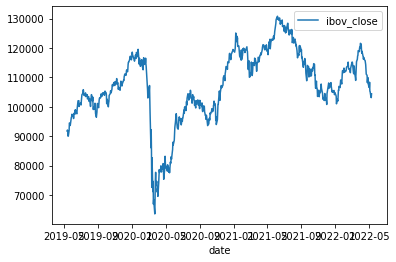

In [23]:
df.plot(y='ibov_close')

<AxesSubplot:xlabel='date'>

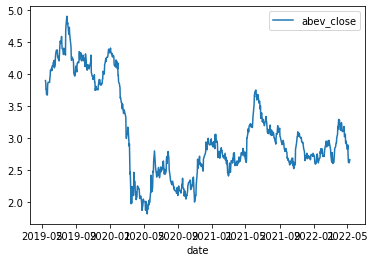

In [24]:
df.plot(y='abev_close')

In [28]:
df = df.join(df[['ibov_close', 'abev_close']].rolling(50).mean()\
             .rename({'ibov_close': 'ibov_long_ma', 'abev_close': 'abev_long_ma'}, axis=1))
df = df.join(df[['ibov_close', 'abev_close']].rolling(20).mean()\
             .rename({'ibov_close': 'ibov_short_ma', 'abev_close': 'abev_short_ma'}, axis=1))
df = df.join(df[['abev_volume']].rolling(20).mean()\
             .rename({'abev_volume': 'abev_volume_ma'}, axis=1))
df = df.dropna()

In [31]:
df

symbol,ibov_close,abev_close,abev_volume,ibov_long_ma,abev_long_ma,ibov_short_ma,abev_short_ma,abev_volume_ma
date,,,,,,,,
2019-07-25,102655.0,4.690587,53426200.0,99072.16,4.172804,103194.35,4.382881,27253840.0
2019-07-26,102819.0,4.763309,21620700.0,99294.00,4.190076,103300.85,4.407425,26980420.0
2019-07-29,103483.0,4.908754,35419600.0,99521.82,4.210620,103438.80,4.438786,27416505.0
2019-07-30,102933.0,4.836032,28687700.0,99748.02,4.232073,103537.10,4.468330,27812460.0
2019-07-31,101812.0,4.790580,32962700.0,99983.78,4.252617,103560.70,4.497418,28032050.0
...,...,...,...,...,...,...,...,...
2022-05-05,105304.0,2.710000,36920400.0,114158.74,2.946800,112524.95,3.027000,25984430.0
2022-05-06,105135.0,2.620000,30263300.0,114006.08,2.941600,111870.30,3.001000,25768240.0
2022-05-09,103250.0,2.610000,38321400.0,113813.24,2.936000,111089.70,2.974500,26684470.0


In [33]:
for key in ['ibov', 'abev']:
    df[f'{key}_ma_return'] = df[f'{key}_short_ma'] / df[f'{key}_long_ma'] - 1
    df[f'{key}_trend'] = df[f'{key}_ma_return'].map(lambda v: -1 if v < -0.03 else 1 if v > 0.03 else 0)

/Users/lucasabbade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lucasabbade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
df['return'] = df['abev_close'].shift(-3) / df['abev_close'] - 1
df['y'] = df[f'return'].map(lambda v: -1 if v < -0.01 else 1 if v > 0.01 else 0)
df = df.dropna()

/Users/lucasabbade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/lucasabbade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
df['volume_per'] = df['abev_volume'] / df['abev_volume_ma']

/Users/lucasabbade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
df['volume_signal'] = df['volume_per'].map(lambda v: -1 if v < 0.9 else 1 if v > 1.1 else 0)

/Users/lucasabbade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
df

symbol,ibov_close,abev_close,abev_volume,ibov_long_ma,abev_long_ma,ibov_short_ma,abev_short_ma,abev_volume_ma,ibov_ma_return,ibov_trend,abev_ma_return,abev_trend,return,y,volume_per,volume_signal
date,,,,,,,,,,,,,,,,
2019-07-25,102655.0,4.690587,53426200.0,99072.16,4.172804,103194.35,4.382881,27253840.0,0.041608,1,0.050344,1,0.031008,1,1.960318,1
2019-07-26,102819.0,4.763309,21620700.0,99294.00,4.190076,103300.85,4.407425,26980420.0,0.040353,1,0.051872,1,0.005725,0,0.801348,-1
2019-07-29,103483.0,4.908754,35419600.0,99521.82,4.210620,103438.80,4.438786,27416505.0,0.039358,1,0.054188,1,-0.020370,-1,1.291908,1
2019-07-30,102933.0,4.836032,28687700.0,99748.02,4.232073,103537.10,4.468330,27812460.0,0.037987,1,0.055825,1,-0.015038,-1,1.031469,0
2019-07-31,101812.0,4.790580,32962700.0,99983.78,4.252617,103560.70,4.497418,28032050.0,0.035775,1,0.057565,1,-0.034156,-1,1.175893,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02,106639.0,2.820000,34277300.0,114622.60,2.953200,114602.90,3.094000,23583920.0,-0.000172,0,0.047677,1,-0.039007,-1,1.453418,1
2022-05-03,106528.0,2.830000,30971900.0,114459.96,2.950800,113850.80,3.071000,24005085.0,-0.005322,0,0.040735,1,-0.074205,-1,1.290222,1
2022-05-04,108344.0,2.890000,35739800.0,114323.22,2.949800,113204.00,3.051500,24976090.0,-0.009790,0,0.034477,1,-0.096886,-1,1.430961,1


In [43]:
def p(df, col, v, y):
    return len(df[(df[col] == v) & (df['y'] == y)]) / len(df[df['y'] == y])

In [44]:
def lambdas_for_h(h):
    return [
        p(df, 'abev_trend', -1, h),
        p(df, 'abev_trend', 0, h),
        p(df, 'abev_trend', 1, h),
        p(df, 'ibov_trend', -1, h),
        p(df, 'ibov_trend', 0, h),
        p(df, 'ibov_trend', 1, h),
        p(df, 'volume_signal', -1, h),
        p(df, 'volume_signal', 0, h),
        p(df, 'volume_signal', 1, h)
    ]

In [45]:
lambdas = [
    lambdas_for_h(-1),
    lambdas_for_h(0),
    lambdas_for_h(1)
]

In [47]:
def prior(df, h):
    return len(df[df['y'] == h]) / len(df)

In [48]:
priors = [prior(df, i) for i in [-1, 0, 1]]

In [49]:
table = BayesTable(lambdas, priors, 3)
table()

,e11,e12,e13,e21,e22,e23,e31,e32,e33,prior
H1,0.331010,0.320557,0.348432,0.219512,0.498258,0.282230,0.487805,0.167247,0.344948,0.424556
H2,0.297297,0.405405,0.297297,0.114865,0.668919,0.216216,0.466216,0.202703,0.331081,0.218935
H3,0.394191,0.356846,0.248963,0.107884,0.663900,0.228216,0.460581,0.236515,0.302905,0.356509


In [50]:
table.evidences(['e11', 'e23', 'e31'])

,e11,e12,e13,e21,e22,e23,e31,e32,e33,final
H1,0.331010,0.320557,0.348432,0.219512,0.498258,0.282230,0.487805,0.167247,0.344948,0.475599
H2,0.297297,0.405405,0.297297,0.114865,0.668919,0.216216,0.466216,0.202703,0.331081,0.161286
H3,0.394191,0.356846,0.248963,0.107884,0.663900,0.228216,0.460581,0.236515,0.302905,0.363115


In [51]:
table.evidences(['e12', 'e22', 'e33'])

,e11,e12,e13,e21,e22,e23,e31,e32,e33,final
H1,0.331010,0.320557,0.348432,0.219512,0.498258,0.282230,0.487805,0.167247,0.344948,0.340821
H2,0.297297,0.405405,0.297297,0.114865,0.668919,0.216216,0.466216,0.202703,0.331081,0.286411
H3,0.394191,0.356846,0.248963,0.107884,0.663900,0.228216,0.460581,0.236515,0.302905,0.372768


In [52]:
table.evidences(['e13', 'e23', 'e32'])

,e11,e12,e13,e21,e22,e23,e31,e32,e33,final
H1,0.331010,0.320557,0.348432,0.219512,0.498258,0.282230,0.487805,0.167247,0.344948,0.477407
H2,0.297297,0.405405,0.297297,0.114865,0.668919,0.216216,0.466216,0.202703,0.331081,0.195041
H3,0.394191,0.356846,0.248963,0.107884,0.663900,0.228216,0.460581,0.236515,0.302905,0.327552
